In [72]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


from   sklearn.metrics import classification_report
from   sklearn.metrics import confusion_matrix

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from keras.preprocessing.image import ImageDataGenerator


Графік кількості зображень для кожного класу:

C:\Users\MSI\AppData\Local\Temp\ipykernel_21732\1873309638.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df.groupby('label')['id'].count().sort_values(ascending=False)


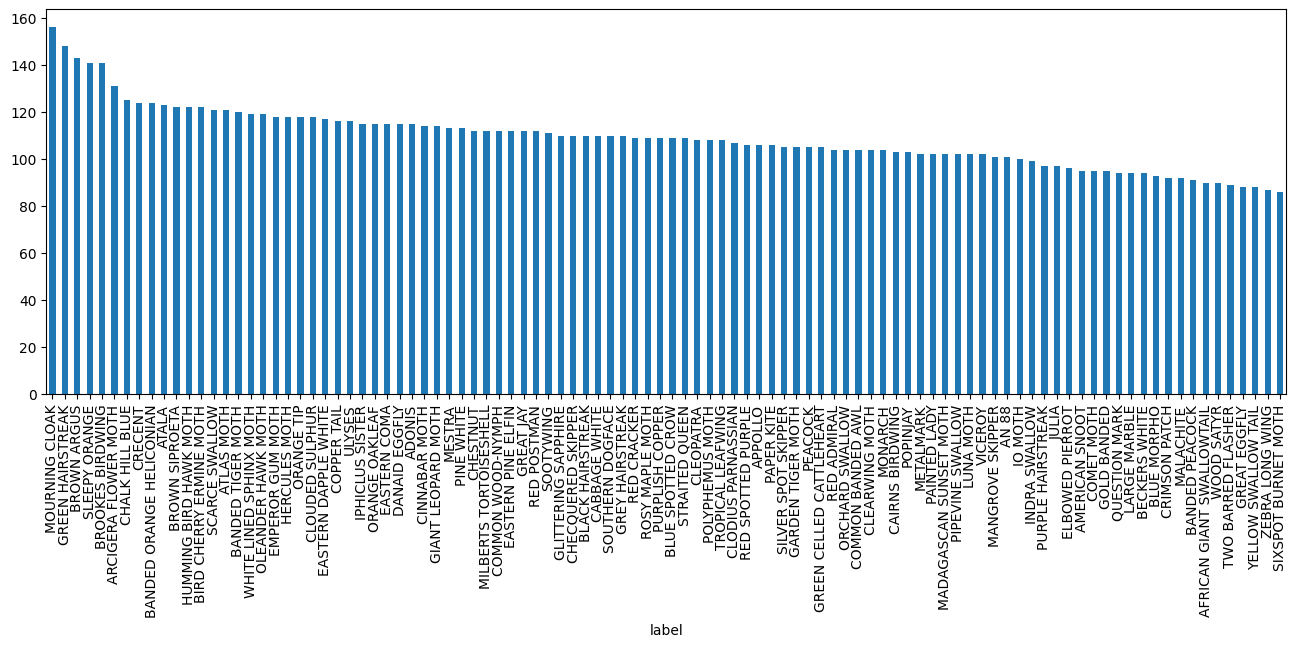

In [24]:
dtypes = {
    "id": "category",
    "path": "category",
    "label": "category",
}
df = pd.read_csv(
    "train.csv",
    dtype=dtypes,
)
df.dtypes
data = df.groupby('label')['id'].count().sort_values(ascending=False)

ax = data.plot.bar(figsize=(16,5))


Зменшення кількості зображень з кожним класом, для коректного навчання згенеруємо додаткові зображення на основі одного з наявних, для кодного класу де кількість зображень менша за середнє. Preprocessing.ipynb

In [37]:
TRAIN_DIR = 'C:/Users/MSI/Documents/MachineLearning/Butterfly_Classification/trainC'
VALID_DIR = 'C:/Users/MSI/Documents/MachineLearning/Butterfly_Classification/validation'

In [38]:
datagen = ImageDataGenerator(rescale=1./255) 

In [39]:
train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14040 images belonging to 100 classes.


In [40]:
valid_gen = datagen.flow_from_directory(
    VALID_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1560 images belonging to 100 classes.


In [41]:
input_shape = (224, 224, 3)
num_classes = 100

In [44]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [45]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [50]:
 #Model architecture with regularization and modified dropout
reg_strength = 0.001
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength), input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    Flatten(),

    Dense(512, activation='relu', kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    Dropout(0.6),

    Dense(num_classes, activation='softmax')
])

In [51]:
#
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
# Training the model
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10


439/439 [==============================] - 1254s 3s/step - loss: 6.8349 - accuracy: 0.2017 - val_loss: 9.4972 - val_accuracy: 0.0571 - lr: 0.0010
Epoch 2/10
439/439 [==============================] - 1226s 3s/step - loss: 6.3457 - accuracy: 0.4155 - val_loss: 24.1061 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/10
439/439 [==============================] - 1173s 3s/step - loss: 8.2490 - accuracy: 0.4765 - val_loss: 8.6973 - val_accuracy: 0.5404 - lr: 0.0010
Epoch 4/10
439/439 [==============================] - 1201s 3s/step - loss: 8.6999 - accuracy: 0.5727 - val_loss: 10.6017 - val_accuracy: 0.3840 - lr: 0.0010
Epoch 5/10
439/439 [==============================] - ETA: 0s - loss: 9.3384 - accuracy: 0.6382
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
439/439 [==============================] - 1235s 3s/step - loss: 9.3384 - accuracy: 0.6382 - val_loss: 10.0592 - val_accuracy: 0.6295 - lr: 0.0010
Epoch 6/10
439/439 [============================

In [53]:
# Print final accuracy and loss for training and validation sets
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

In [54]:
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

Final Training Accuracy: 95.28%
Final Validation Accuracy: 73.78%


Text(0.5, 1.0, 'Training vs Validation Accuracy')

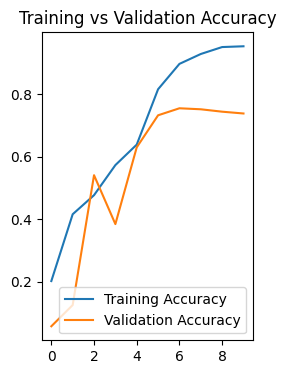

In [59]:
plt.figure(figsize=(6, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

Text(0.5, 1.0, 'Training vs Validation Loss')

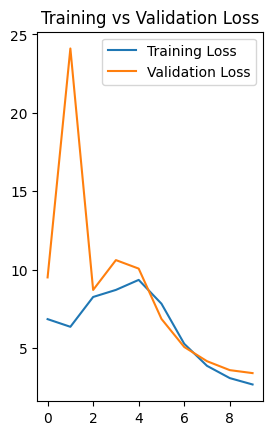

In [61]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')

In [62]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [64]:
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)

49/49 [==============================] - 27s 480ms/step


In [65]:
y_true = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)

In [70]:
print(report)

                           precision    recall  f1-score   support

                   ADONIS       0.00      0.00      0.00        16
AFRICAN GIANT SWALLOWTAIL       0.00      0.00      0.00        16
           AMERICAN SNOOT       0.00      0.00      0.00        16
                    AN 88       0.07      0.06      0.07        16
                  APPOLLO       0.08      0.06      0.07        16
     ARCIGERA FLOWER MOTH       0.00      0.00      0.00        16
                    ATALA       0.00      0.00      0.00        15
               ATLAS MOTH       0.00      0.00      0.00        15
 BANDED ORANGE HELICONIAN       0.00      0.00      0.00        15
           BANDED PEACOCK       0.00      0.00      0.00        15
        BANDED TIGER MOTH       0.00      0.00      0.00        16
            BECKERS WHITE       0.00      0.00      0.00        16
  BIRD CHERRY ERMINE MOTH       0.00      0.00      0.00        15
         BLACK HAIRSTREAK       0.00      0.00      0.00     

In [71]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()


NameError: name 'itertools' is not defined

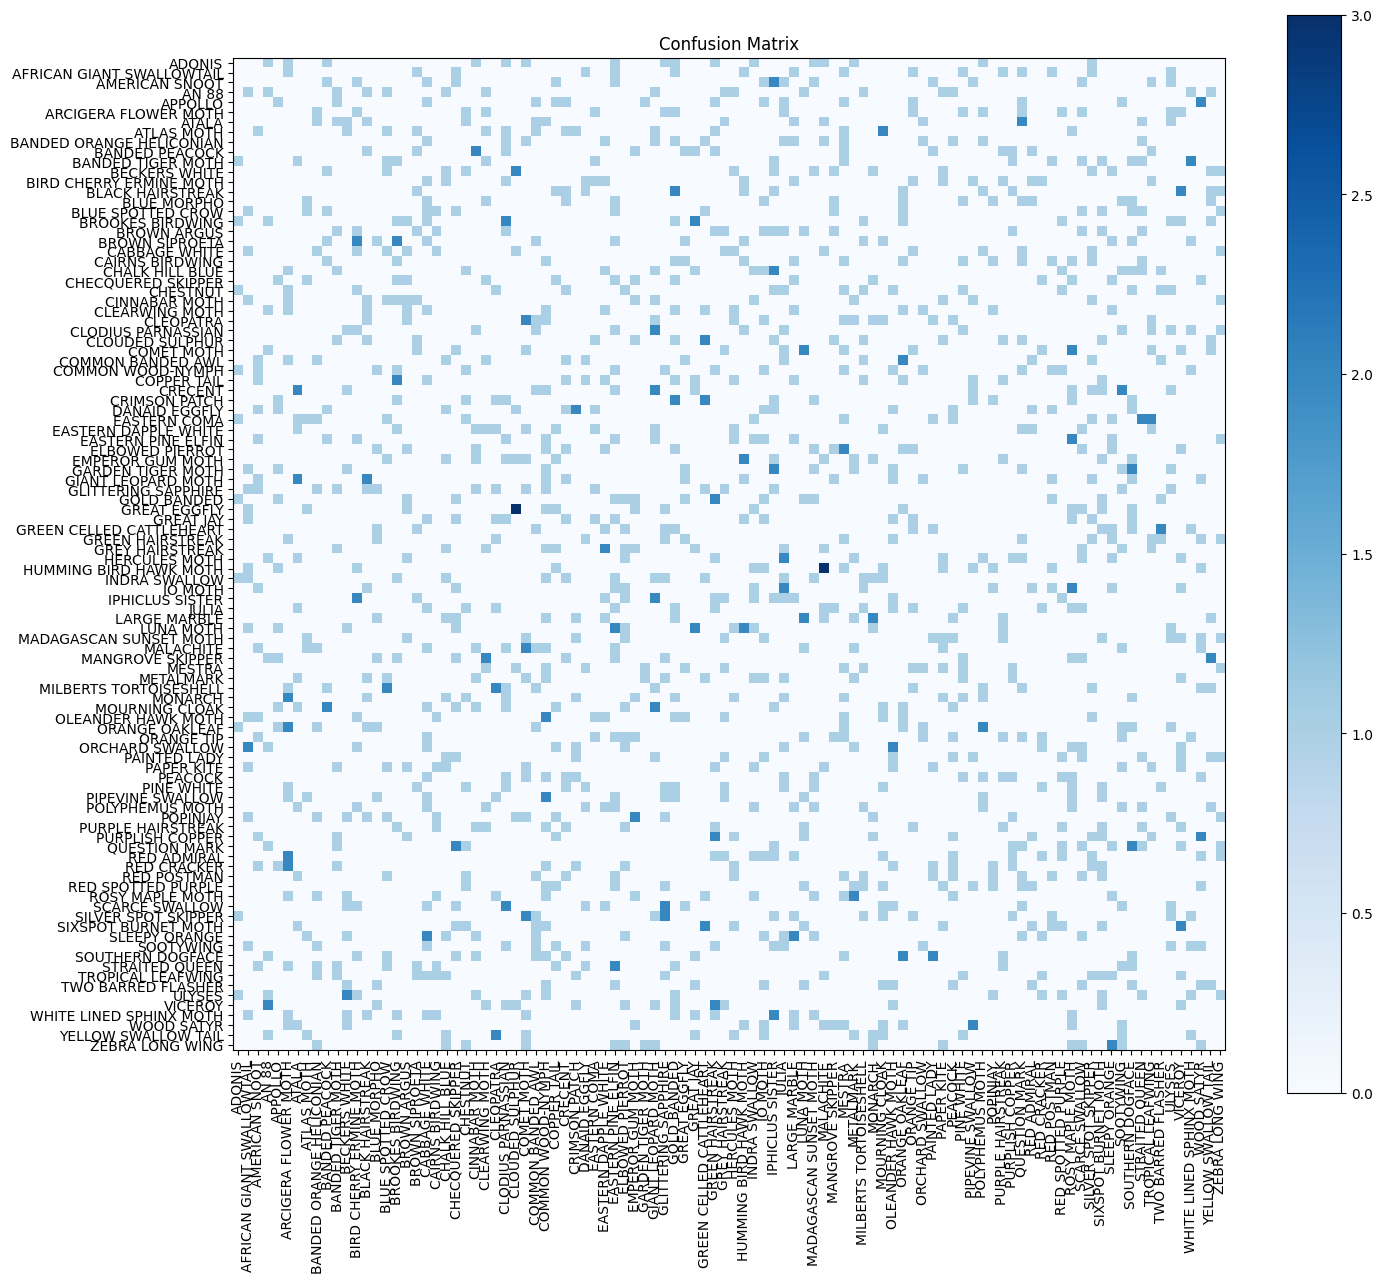

In [74]:
species_names = os.listdir(TRAIN_DIR)
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using the defined function
plot_confusion_matrix(cm, species_names, figsize=(16, 14))